In [1]:
import core.vem as vem
import numpy as np
import matplotlib.pyplot as plt

# Define the load function
def f(c):
    return -np.sin(np.pi*c[0])*np.sin(np.pi*c[1])

# Generate a structured mesh on the unit square
def unit_square_mesh(nx, ny):
    hx = 1.0 / (nx - 1)
    hy = 1.0 / (ny - 1)
    nodes = np.array([[i*hx, j*hy] for j in range(ny) for i in range(nx)])
    elements = []
    for j in range(ny - 1):
        for i in range(nx - 1):
            n0 = i + j*nx
            n1 = n0 + 1
            n2 = n0 + nx
            n3 = n2 + 1
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return nodes, np.array(elements)

# Function to get boundary node indices
def get_boundary_nodes(nodes):
    tol = 1e-12
    boundary_indices = np.where((np.abs(nodes[:, 0]) < tol) | (np.abs(nodes[:, 0] - 1) < tol) |
                                (np.abs(nodes[:, 1]) < tol) | (np.abs(nodes[:, 1] - 1) < tol))[0]
    return boundary_indices

# Parameters
nx = 31  # Number of nodes in x direction
ny = 31  # Number of nodes in y direction
nodes, elements = unit_square_mesh(nx, ny)
supp = get_boundary_nodes(nodes)


#################### Poisson #####################
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00055438 -0.00110204 -0.00163726 -0.00215429
 -0.00264756 -0.00311171 -0.00354167 -0.00393276 -0.00428071 -0.00458173
 -0.00483252 -0.00503033 -0.00517302 -0.00525903 -0.00528741 -0.00525786
 -0.00517071 -0.00502692 -0.00482806 -0.00457633 -0.00427449 -0.00392586
 -0.00353427 -0.00310402 -0.00263985 -0.00214687 -0.00163054 -0.00109659
 -0.00055099  0.          0.         -0.00110204 -0.00219113 -0.0032556
 -0.004284   -0.00526516 -0.0061884  -0.00704368 -0.00782166 -0.00851384
 -0.00911267 -0.00961161 -0.01000519 -0.01028913 -0.01046032 -0.01051689
 -0.01045824 -0.01028501 -0.00999912 -0.

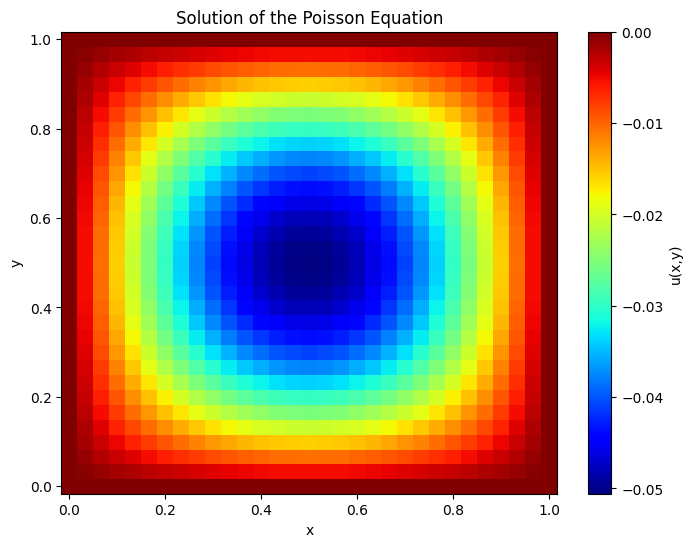

In [2]:
K = vem.buildGlobalPoisson(nodes, elements)
F = vem.buildPoissonLoad(f, nodes, elements)

K, F = vem.applyPoissonDBC(K,F, supp)

print()
print("#################### Poisson #####################")
uh = np.linalg.solve(K,F)
print(uh)
print("####################################################")

# Reshape the solution to fit the mesh
h = int(np.sqrt(len(nodes))) - 1
uh_reshaped = uh.reshape((h+1, h+1))

# Create meshgrid for plotting
X = nodes[:, 0].reshape((h+1, h+1))
Y = nodes[:, 1].reshape((h+1, h+1))

# Plot the results
plt.figure(figsize=(8, 6))
plt.pcolor(X, Y, uh_reshaped, cmap='jet')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the Poisson Equation')
plt.show()


#################### Poisson #####################
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00055438 -0.00110204 -0.00163726 -0.00215429
 -0.00264756 -0.00311171 -0.00354167 -0.00393276 -0.00428071 -0.00458173
 -0.00483252 -0.00503033 -0.00517302 -0.00525903 -0.00528741 -0.00525786
 -0.00517071 -0.00502692 -0.00482806 -0.00457633 -0.00427449 -0.00392586
 -0.00353427 -0.00310402 -0.00263985 -0.00214687 -0.00163054 -0.00109659
 -0.00055099  0.          0.         -0.00110204 -0.00219113 -0.0032556
 -0.004284   -0.00526516 -0.0061884  -0.00704368 -0.00782166 -0.00851384
 -0.00911267 -0.00961161 -0.01000519 -0.01028913 -0.01046032 -0.01051689
 -0.01045824 -0.01028501 -0.00999912 -0.

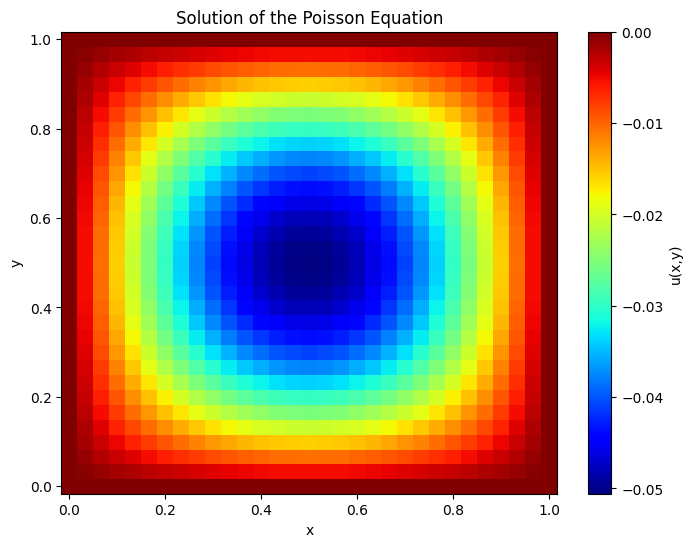

In [3]:
# not using Ks
K = vem.buildGlobalPoisson(nodes, elements, use_stabilization=False)
F = vem.buildPoissonLoad(f, nodes, elements)

K, F = vem.applyPoissonDBC(K,F, supp)

print()
print("#################### Poisson #####################")
uh = np.linalg.solve(K,F)
print(uh)
print("####################################################")

# Reshape the solution to fit the mesh
h = int(np.sqrt(len(nodes))) - 1
uh_reshaped = uh.reshape((h+1, h+1))

# Create meshgrid for plotting
X = nodes[:, 0].reshape((h+1, h+1))
Y = nodes[:, 1].reshape((h+1, h+1))

# Plot the results
plt.figure(figsize=(8, 6))
plt.pcolor(X, Y, uh_reshaped, cmap='jet')
plt.colorbar(label='u(x,y)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solution of the Poisson Equation')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

# Define a neural network to approximate an n x n matrix
class MatrixApproximator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MatrixApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
input_dim = nx * ny  # Input dimension corresponding to each element in the matrix
output_dim = nx * ny  # Output dimension corresponding to each element in the matrix

model = MatrixApproximator(input_dim, output_dim)
loss = compute_loss(torch.tensor(K), torch.tensor(uh), torch.tensor(F))

In [5]:
# geometry data
L = 2.0
nodes = np.array([[0,0],[0,L],[L,L],[L,0]])
elements = np.array([[0,1],[1,2],[2,3]])
supp = np.array([[0,1,1,1], [3,1,1,1]])
I = 36e-4
A = 0.12

# material data
E = 20e6

# loads
load = np.array([[1,2]])
q = -400
t = 0
f_dist = vem.buildBeamDistributedLoad(load,t,q,nodes)

# stiffness matrix
K = vem.buildGlobaBeamK(nodes, elements, E, A, I, 1)

# apply DBC
K, f = vem.applyDBCBeam(K, f_dist, supp)

# solve
print()
print("######################### Beam ##########################")
uh_vem = np.linalg.solve(K,f)
print(uh_vem)
print("#########################################################")


######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.16360817e-04
 -3.20308731e-04 -8.04745594e-04  5.44061872e-05 -3.46357935e-04
  6.33978590e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
#########################################################


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

def compute_loss(K, uh, F):
    """
    Compute the loss function as (K * uh - F)^2 using PyTorch

    Parameters:
    K (torch.Tensor): Stiffness matrix (ndof x ndof)
    uh (torch.Tensor): Solution vector (ndof x 1)
    F (torch.Tensor): Load vector (ndof x 1)

    Returns:
    torch.Tensor: The loss value
    """
    # Compute the residual
    R = torch.matmul(K, uh) - F
    
    # Compute the loss (squared residual)
    loss = torch.sum(R**2)
    
    return loss

def compute_boundary_loss(uh, supp):
    """
    Compute the loss function for enforcing the Dirichlet boundary conditions.

    Parameters:
    uh (torch.Tensor): Solution vector (ndof x 1)
    supp (torch.Tensor): Support vector (ndof x N, where N is the number of nodes with boundary conditions)

    Returns:
    torch.Tensor: The loss value as a PyTorch tensor
    """
    # Initialize the loss as a scalar tensor with zero
    loss = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)
    
    for node in supp:
        if node[1] == 1:  # x-direction fixed
            k = 3 * int(node[0])
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[2] == 1:  # y-direction fixed
            k = 3 * int(node[0]) + 1
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor
        if node[3] == 1:  # z-direction fixed
            k = 3 * int(node[0]) + 2
            loss = loss + uh[k] ** 2  # Avoid in-place operation by using a new tensor

    return loss

# Define neural network for the beam problem
class BeamApproximator(nn.Module):
    def __init__(self, input_dim, ndof):
        super(BeamApproximator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, ndof)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Assuming nodes, K, and f are already defined
ndof = 3 * len(nodes)
input_dim = 2*len(nodes)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

# Initialize the model and optimizer
model = BeamApproximator(input_dim, ndof)
optimizer = optim.Adam(model.parameters(), lr=0.01)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

/opt/anaconda3/envs/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
epochs = 4000
for  epoch in range(epochs):
    optimizer.zero_grad()
    uh = model(nodes)
    loss = compute_loss(K, uh, f)
    loss_bc = compute_boundary_loss(uh, supp)
    loss = loss + loss_bc
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1}, Loss: {loss.item()}')

Epoch: 1, Loss: 353880965120.0
Epoch: 2, Loss: 3731007471616.0
Epoch: 3, Loss: 481538768896.0
Epoch: 4, Loss: 175327723520.0
Epoch: 5, Loss: 565537341440.0
Epoch: 6, Loss: 543373066240.0
Epoch: 7, Loss: 318376280064.0
Epoch: 8, Loss: 126067834880.0
Epoch: 9, Loss: 28526614528.0
Epoch: 10, Loss: 5882310144.0
Epoch: 11, Loss: 27156213760.0
Epoch: 12, Loss: 49927208960.0
Epoch: 13, Loss: 55234711552.0
Epoch: 14, Loss: 45332430848.0
Epoch: 15, Loss: 30868183040.0
Epoch: 16, Loss: 18025183232.0
Epoch: 17, Loss: 9844335616.0
Epoch: 18, Loss: 6384958976.0
Epoch: 19, Loss: 4485777920.0
Epoch: 20, Loss: 2725356544.0
Epoch: 21, Loss: 1277632640.0
Epoch: 22, Loss: 629239424.0
Epoch: 23, Loss: 1206409216.0
Epoch: 24, Loss: 1539283200.0
Epoch: 25, Loss: 1671579776.0
Epoch: 26, Loss: 1617837568.0
Epoch: 27, Loss: 1413128192.0
Epoch: 28, Loss: 1129185152.0
Epoch: 29, Loss: 844452224.0
Epoch: 30, Loss: 620719616.0
Epoch: 31, Loss: 490253760.0
Epoch: 32, Loss: 453672736.0
Epoch: 33, Loss: 486259776.0
E

In [8]:
uh

tensor([-3.7253e-09, -1.8626e-09, -1.8626e-09,  1.1627e-04, -3.2031e-04,
        -8.0471e-04,  5.4318e-05, -3.4635e-04,  6.3401e-04, -1.8626e-09,
         0.0000e+00,  3.7253e-09], grad_fn=<ViewBackward0>)

In [9]:
# Set the model to evaluation mode
model.eval()

# Ensure gradients are not tracked during prediction
with torch.no_grad():
    # Use the trained model to make predictions
    predicted_displacements = model(nodes)

# Print or use the predicted displacements
print("Predicted displacements:", predicted_displacements)

Predicted displacements: tensor([ 0.0000e+00, -1.8626e-09, -1.8626e-09,  1.1627e-04, -3.2031e-04,
        -8.0471e-04,  5.4318e-05, -3.4635e-04,  6.3401e-04, -1.8626e-09,
        -1.8626e-09,  3.7253e-09])


In [13]:
def compute_l2_error(uh_vem, uh_nn):
    """
    Compute the L2 norm error between the FEM and NN displacement fields.

    Parameters:
    uh_fem (torch.Tensor): Displacement field from FEM (ndof x 1)
    uh_nn (torch.Tensor): Displacement field from NN (ndof x 1)

    Returns:
    torch.Tensor: L2 norm error as a scalar
    """
    error = torch.norm(uh_nn - uh_vem) / torch.norm(uh_vem)
    return error

In [ ]:
compute_l2_error(torch.tensor(uh_vem), predicted_displacements)